In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

import h5py

from power import my_fft

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

arcmin = 2.908882086656e-4 # [rad] ... PI / 180 / 60 //
arcsec = 4.848136811094e-6 # [rad] ... arcmin / 60 //

def arcsec_to_cMpc(l_arcsec, z):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)
    return cosmo.comoving_distance(z).to(u.Mpc).value

line_ids = [f"co_{i}_{i-1}" for i in range(2, 13)]
freq_rest_dict = {
    "CO(2-1)": 230.538,
    "CO(3-2)": 345.796,
    "CO(4-3)": 461.041,
    "CO(5-4)": 576.268,
    "CO(6-5)": 691.473,
    "CO(7-6)": 806.652,
    "CO(8-7)": 921.800,
    "CO(9-8)": 1036.912,
    "CO(10-9)": 1151.985,
    "CO(11-10)": 1267.014,
    "CO(12-11)": 1381.995,
    #"[CII]158": 1900.537,
}
line_names = list(freq_rest_dict.keys())
NLINE = len(line_names)
print(line_names)

['CO(2-1)', 'CO(3-2)', 'CO(4-3)', 'CO(5-4)', 'CO(6-5)', 'CO(7-6)', 'CO(8-7)', 'CO(9-8)', 'CO(10-9)', 'CO(11-10)', 'CO(12-11)']


In [2]:
def load_data(fname_id="./output/run0_index0"):

    intensity_line = []
    for i in range(NLINE):
        with h5py.File(f"{fname_id}_{line_ids[i]}.h5", "r") as f:
            frequency = f["/frequency"][:] * 1e-9 # [GHz]
            intensity_line.append(f["/intensity"][:])

        if frequency[0] > frequency[-1]:
            frequency = frequency[::-1]
            intensity_line[i] = intensity_line[i][:, :, ::-1]

    intensity_line = np.array(intensity_line)
    intensity = intensity_line.sum(axis=0)

    print("freqency shape: ", frequency.shape)
    print("intensity shape: ", intensity.shape)
    print("intensity_line shape: ", intensity_line.shape)
    return frequency, intensity, intensity_line

def plot_mean(frequency, intensity, intensity_line, title=None, lines_to_show=line_names, ylim=None, nsmooth=1, logx=False):
    """
    plot mean intensity
    input: 
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        title: title of the plot
        lines_to_show: list of line names to show
        ylim: y-axis limit
        nsmooth: smoothing scale
        logx: if True, use log scale for x-axis
    """

    plt.figure()
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Mean intensity [Jy/sr]")

    frequency_bin = 0.5 * (frequency[1:] + frequency[:-1])
    mean = np.mean(intensity, axis=(0, 1))
    if nsmooth > 1:
        mean = gaussian_filter(mean, sigma=nsmooth)
    plt.plot(frequency_bin, mean, color="k", label="total")

    count = 0
    for i in range(NLINE):
        if line_names[i] in lines_to_show:
            mean_line = np.mean(intensity_line[i], axis=(0, 1))
            if nsmooth > 1:
                mean_line = gaussian_filter(mean_line, sigma=nsmooth)

            ls = "-" if count < 10 else "--"
            plt.plot(frequency_bin, mean_line, ls=ls, label=f"{line_names[i]}")
            count += 1

    if len(lines_to_show) > 4:
        plt.legend(bbox_to_anchor=(1,1.1))
    else:
        plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.yscale("log")
    if logx:
        plt.xscale("log")
    
def show_map(frequency, intensity, intensity_line, side_length, lines_to_show=line_names, use_log=False, smoothing=0):
    """
    show intensity map in x-z plane
    input:
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        side_length: side length [arcsec]
        lines_to_show: list of line names to show
        use_log: if True, use log scale for intensity
        smoothing: smoothing scale
    """

    Nmap = len(lines_to_show) + 1
    line_ids = [line_names.index(name) for name in lines_to_show]

    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=1)

    fmin = frequency[0]
    fmax = frequency[-1]

    def show_ticks(fmin=fmin, fmax=fmax, freq=frequency):
        if fmax - fmin < 150:
            tick_values = [ int(fmin/100) * 100 + 20*i for i in range(10) ]
        else:
            tick_values = [ int(fmin/100) * 100 + 100*i for i in range(10) ]
        tick_values = [v for v in tick_values if v > fmin and v < fmax]
        interpolator = interp1d(freq, np.arange(len(freq)))
        tick_positions = interpolator(tick_values)
        plt.xticks(ticks=tick_positions, labels=tick_values)

    def show_a_map(imap, map, side_length=side_length, iy=0, vmin=None, vmax=None, label=None, use_log=use_log):
        plt.subplot2grid((Nmap,1), (imap,0))
        map_xz = map[:, iy, :]
        if use_log: map_xz = np.log10(map_xz)
        if smoothing > 0:
            map_xz = gaussian_filter(map_xz, sigma=smoothing)
        cmap = plt.cm.viridis
        cmap.set_bad(color=cmap(0))
        plt.imshow(map_xz, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(label)
        plt.colorbar(label="log I [Jy/sr]")
        plt.yticks([])
        x = side_length / 3600
        plt.ylabel("{:.1f} deg".format(x))
        plt.xlabel("frequency [GHz]")
        show_ticks()

    show_a_map(0, intensity, label="total")
    for i, iline in enumerate(line_ids):
        show_a_map(i+1, intensity_line[iline], label=line_names[iline])

def calc_noise_power(sigma_noise_Jy_sr, dV):

    P_noise = sigma_noise_Jy_sr**2 * dV
    return P_noise


def calc_power(freq_obs, intensity, side_length=3600, line_name="CO(1-0)", dlogk=0.2, with_hlittle=True, logkpara_min=-10, logkperp_min=-10, sigma_noise=0): 
    """
    input:
        freq: (N,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [arbitrary unit]
        side_length: side length [arcsec]
        line_name: line name for which the distance is calculated
        dlogk: bin width for logk
        with_hlittle: if True, multiply h
        logkpara_min: minimum value of logkpara
        logkperp_min: minimum value of logkperp
    output:
        k: (Nk,) wavenumber [h/cMpc^-1]
        power1d: (Nk,) power spectrum [input unit^2 * (cMpc/h)^3]
    """
    
    redshifts = freq_rest_dict[line_name] / freq_obs - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = freq_rest_dict[line_name]

    print(f"Use {line_name} rest-frame frequency")
    print(f"redshift: {redshifts[-1]:.2f} - {redshifts[0]:.2f} (mean: {redshift_mean:.2f})")
    
    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Lz = freq_to_comdis(freq_obs[0], nu_rest) - freq_to_comdis(freq_obs[-1], nu_rest) # [cMpc]

    dx = Lx / intensity.shape[0]
    dy = Ly / intensity.shape[1]
    dz = Lz / intensity.shape[2]

    L = np.array([Lx, Ly, Lz])
    dL = np.array([dx, dy, dz])
    hlittle = cosmo.H0.value / 100
    if with_hlittle:
        L *= hlittle # [cMpc/h]
        dL *= hlittle
    V = np.prod(L) 
    dV = np.prod(dL) 
    
    ## Fourier transform
    ft, freq = my_fft(intensity, L=L)
    power_spectrum = np.abs(ft)**2 / V
    kx, ky, kz = np.meshgrid(freq[0], freq[1], freq[2], indexing='ij')

    ## noise power spectrum
    power_noise = calc_noise_power(sigma_noise, dV)

    ## compute angular-averaged power spectrum
    logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
    logkpara = np.log10(np.abs(kz))
    logkperp = np.log10(np.sqrt(kx**2 + ky**2))
    
    logk_bins = np.arange(-1.4, 1.3, dlogk)#dk=k*dlogk
    
    power1d = np.zeros(len(logk_bins) - 1)
    power1d_err = np.zeros(len(logk_bins) - 1)
    for i in range(len(logk_bins) - 1):
        mask = (logk >= logk_bins[i]) & (logk < logk_bins[i+1]) & (logkpara > logkpara_min) & (logkperp > logkperp_min)
        Nk = mask.sum()

        if np.any(mask):
            power1d[i] = np.mean(power_spectrum[mask])
            power1d_err[i] = (power1d[i] + power_noise) / np.sqrt(Nk)

    return 10**(0.5*(logk_bins[1:]+logk_bins[:-1])), power1d, power1d_err

In [ ]:
with_hlittle = False
freq, intensity, intensity_line = load_data(fname_id="./output/run1000_index0")

sigma_noise = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]

## set frequency range 
freq = freq[20:70]
intensity = intensity[:,:,20:70]
intensity_line = intensity_line[:,:,:,20:70]

## compute power spectrum 
target_line = "[CII]158" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle, sigma_noise=sigma_noise)
for i, l in enumerate(line_names):
    if l == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[i], side_length=side_length, line_name=l, with_hlittle=with_hlittle)
 
## mock observation with noise intensity
intensity_noise = np.random.normal(0, sigma_noise, intensity.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(sigma_noise, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)

## plot power spectrum
plt.xscale("log")
plt.yscale("log")
plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz")

#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label="[CII]")
plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
plt.plot(k, power,  label="total power")

plt.plot(k, power_w_noise, label="observed (w/ noise)")
plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

if with_hlittle:
    plt.xlabel(r"$k \ [h\ \rm Mpc^{-1}]$")
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ (cMpc/h)^3]$")
else:
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$") 
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")

plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

freqency shape:  (91,)
intensity shape:  (100, 100, 90)
intensity_line shape:  (11, 100, 100, 90)


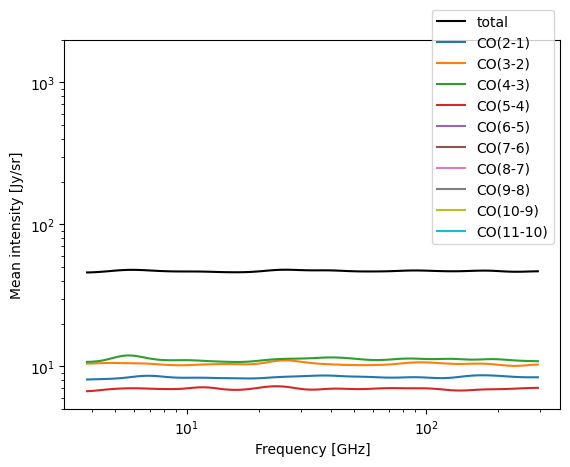

In [12]:
freq, intensity, intensity_line = load_data(fname_id="./output_R20/run1000_index0")
plot_mean(freq, intensity, intensity_line, lines_to_show=["CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)"], ylim=[5, 2e3], nsmooth=3, logx=True)

freqency shape:  (91,)
intensity shape:  (100, 100, 90)
intensity_line shape:  (11, 100, 100, 90)


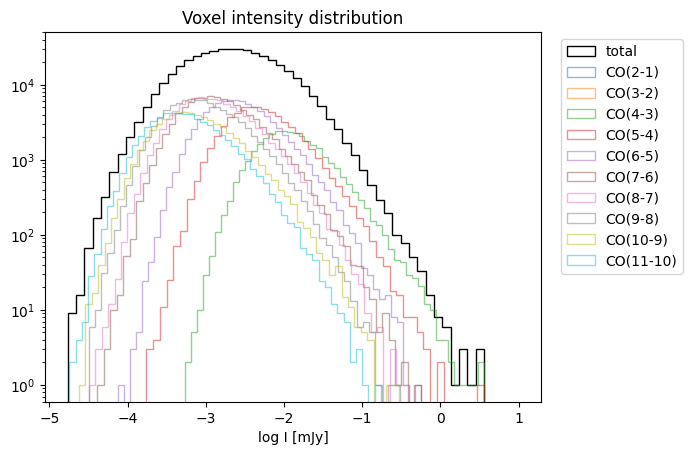

In [10]:
dtheta = 27
freq, intensity, intensity_line = load_data(fname_id="./output/run1000_index0")

int_min = 1 * (dtheta*arcsec)**2 * 1e3 
intensity = intensity.reshape(-1) 
intensity_line = intensity_line.reshape(NLINE, -1) 

intensity *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
intensity_line *= (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]

plt.title("Voxel intensity distribution")

intensity = intensity[intensity > int_min]
plt.hist(np.log10(intensity), bins=50, color="k", label="total", histtype="step")
count = 0
for i in range(NLINE):
    if line_names[i] in ["CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)"]:
        temp = intensity_line[i]
        temp = temp[temp > int_min]

        alpha = 0.5 if count < 10 else 1
        plt.hist(np.log10(temp), bins=50, alpha=alpha, label=line_names[i], histtype="step")
        count += 1

plt.xlabel("log I [mJy]")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.3,1))

freqency shape:  (91,)
intensity shape:  (100, 100, 90)
intensity_line shape:  (11, 100, 100, 90)


Text(0, 0.5, 'intneisyt [Jy/sr] (272.19 GHz)')

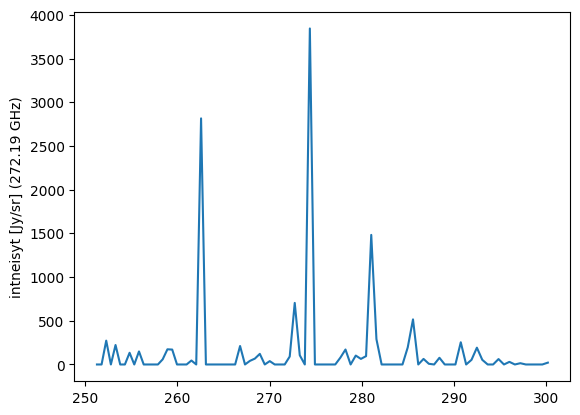

In [9]:
## test scan speed
freq, intensity, intensity_line = load_data(fname_id="./output/run1000_index0")
plt.plot(freq[:-1], intensity[0,0,:])
plt.ylabel(f"intneisyt [Jy/sr] ({freq[40]:.2f} GHz)")


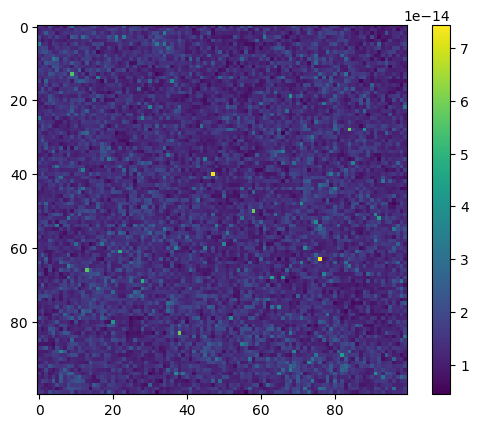

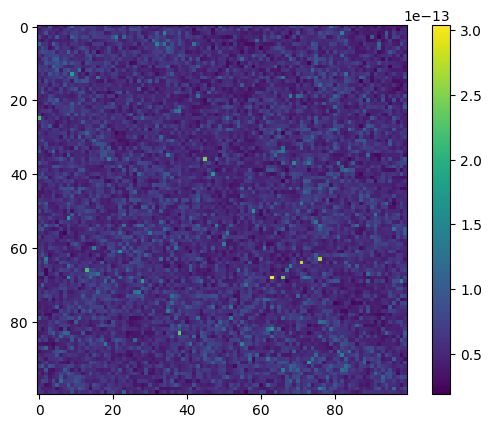

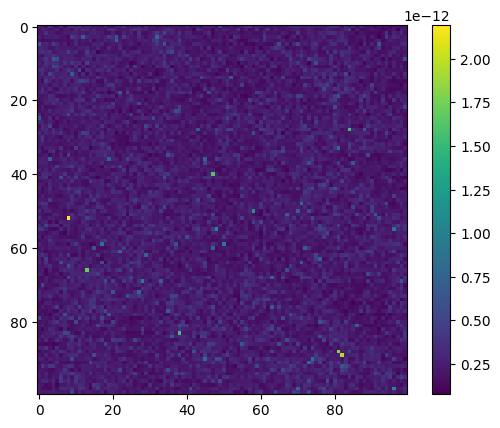

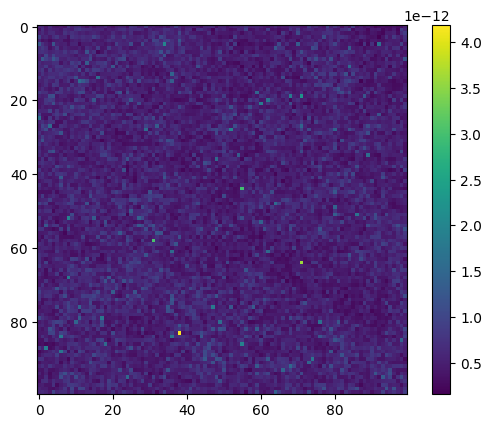

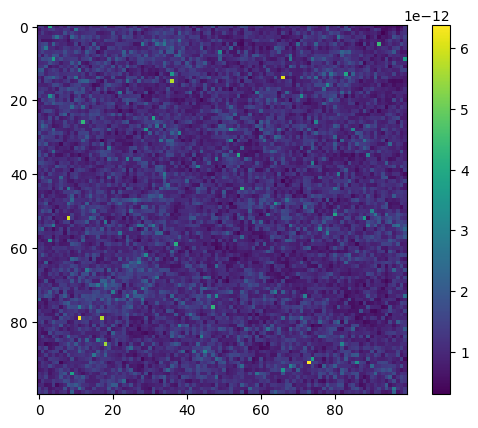

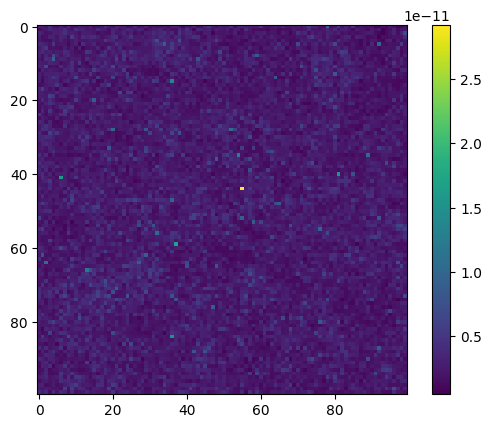

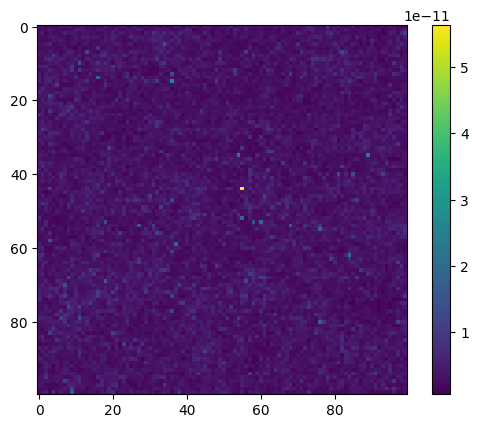

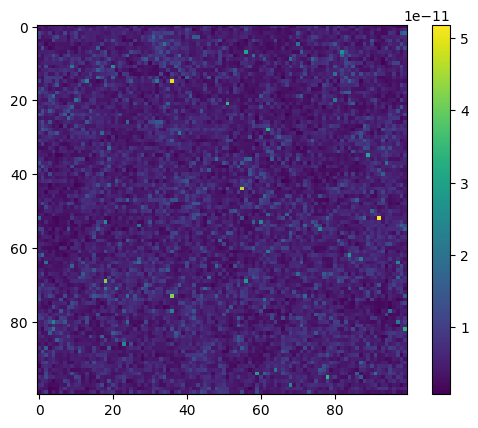

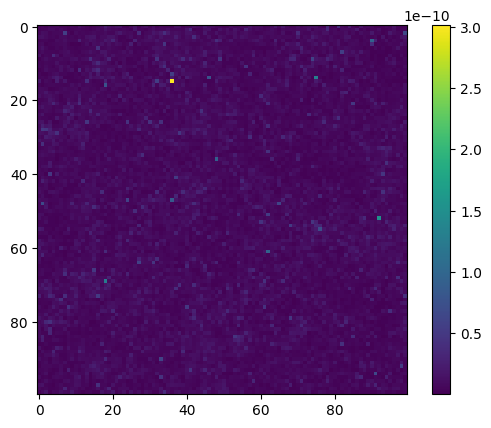

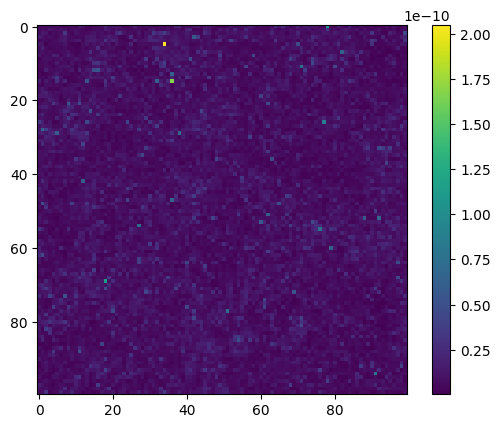

In [6]:
# load fits data
i = 1000
line_list = [f"co_{i}_{i-1}" for i in range(2, 12)]
for line_name in line_list:
    fname = f"./output/run{i}_index0_{line_name}.fits"
    with fits.open(fname) as hdul:
        data = hdul[0].data
        header = hdul[0].header
    
    data = data.astype(np.float32)
    data = data.sum(axis=0)
    plt.figure()
    plt.imshow(data)
    plt.colorbar()